In [1]:
%load_ext memory_profiler

In [2]:
import torch
from skripsi_program import FourierBasis
import matplotlib.pyplot as plt
import numpy as np

In [3]:
ndims = 4
a = torch.arange(12).reshape((-1,ndims))
f = [6,7,8,9]
basis = FourierBasis.fn(a,f)

In [4]:
# def fn1(
#     x: torch.Tensor,
#     modes: int | list[int],
#     periods: int | float | list[float] | list[int] | None = None,
#     constant=2j * torch.pi,
#     transpose: bool = False,
# ) -> torch.Tensor:
#     if isinstance(modes, int):
#         modes = [modes]
#     if isinstance(periods, int):
#         periods = [periods]
#     if isinstance(periods, float):
#         periods = [periods]
#     if periods is None:
#         periods = [1.0 for i in range(len(modes))]

#     assert (
#         len(x.shape) > 1
#     ), "x must have at least 2 dimensions, the format needs to be row of points, the first dimension of the tensor being each row and the second being dimensions of the points"
#     assert (
#         x.shape[0] > 0
#     ), f"x has shape {x.shape}, make sure the first dimension isn't empty ie. has at least one row of samples"
#     assert (
#         x.shape[1] == len(modes)
#     ), f"x has dimensions {x.shape[1]} and modes has dimensions {len(modes)}, both need to have the same dimensions (modes specify how many modes in each dimension of the fourier series)"
#     assert (
#         x.shape[1] == len(periods)
#     ), f"x has dimensions {x.shape[1]} and periods has dimensions {len(periods)}, both need to have the same dimensions (periods the function periodicity in each dimension)"
#     ndims = x.shape[1]

#     # Compute the Fourier basis functions
#     # one time for each dimension

#     dim = 0
#     num_modes = modes[dim]
#     dim_basis_shape = [1 for i in range(ndims + 1)]
#     dim_basis_shape[0] = x.shape[0]
#     dim_basis_shape[dim + 1] = num_modes
#     kx = torch.zeros((x.shape[0], modes[0])).reshape(dim_basis_shape)

#     for dim, num_modes in enumerate(modes):
#         # for dim, num_modes in list(enumerate(modes))[::-1]:
#         k = FourierBasis.waveNumber(num_modes).T
#         dim_basis_shape = [1 for i in range(ndims + 1)]
#         dim_basis_shape[0] = x.shape[0]
#         dim_basis_shape[dim + 1] = num_modes
#         dim_kx = k * x[:, dim : dim + 1] / periods[dim]
#         if transpose:
#             dim_kx = dim_kx.T
#         dim_kx = dim_kx.reshape(dim_basis_shape)

#         kx = kx + dim_kx

#     basis = torch.exp(constant * kx)

#     return basis  # TODO: add multidimensional support

In [5]:
# def _raw_fn(
#     x: torch.Tensor,
#     modes: int,
#     transpose: bool,
#     constant=2j * torch.pi,
# ):
#     k = FourierBasis.waveNumber(modes).T
#     e = torch.exp(constant * k * x)
#     if transpose:
#         e = e.T

#     return e


# def _ndim_fn(
#     x: torch.Tensor,
#     modes: list[int],
#     dim: int,
#     transpose: bool,
#     constant=2j * torch.pi,
# ):
#     # flatten so that each extra dimension is treated as a separate "sample"
#     # move dimension to transform to the end so that it can stay intact after f is flatened
#     # coeff_transposed = modes.transpose(dim, -1)
#     # flatten so that the last dimension is intact
#     # coeff_flatened = coeff_transposed.flatten(0, -2)
#     ndims = len(modes)

#     X_flattened = _raw_fn(
#         x[:, dim : dim + 1], modes[dim], constant=constant, transpose=transpose
#     )
#     X_shape = [1 for i in range(ndims + 1)]
#     X_shape[0] = X_flattened.shape[0]
#     X_shape[dim + 1] = X_flattened.shape[1]
#     X_reshaped = X_flattened.reshape(X_shape)

#     tile_shape = [1 for i in range(ndims + 1)]
#     for cdim, mode in enumerate(modes, 1):
#         if cdim is not dim + 1:
#             tile_shape[cdim] = mode
#     # print(X_reshaped.shape)
#     X_tiled = X_reshaped.tile(tile_shape)
#     # unflatten so that the correct shape is returned
#     # X =
#     # X_transposed = X_flattened.reshape(coeff_transposed.shape)
#     # X = X_transposed.transpose(-1, dim)

#     return X_tiled


# def fn(
#     x: torch.Tensor,
#     modes: int | list[int],
#     constant=2j * torch.pi,
#     transpose: bool = False,
# ):
#     """
#     transform

#     Function to calculate the
#     discrete Fourier Transform
#     of a real-valued signal f

#     Arguments:
#         f {torch.Tensor} -- m discretized real valued functions

#     Returns:
#         torch.Tensor -- m complex valued coefficients of f
#     """
#     if isinstance(modes, int):
#         modes = [modes]
#     ndims = len(modes)
#     assert (
#         ndims == x.shape[1]
#     ), f"modes with ndims {ndims} need have the same dimensions as each row in x with shape {x.shape}"
#     if ndims == 1:
#         X = _raw_fn(x, modes[0], constant=constant, transpose=transpose)
#     elif ndims > 1:
#         # perform 1d transform over every dimension
#         X = _ndim_fn(x, modes, dim=0, constant=constant, transpose=transpose)
#         for cdim in range(1, ndims):
#             X = X * _ndim_fn(x, modes, dim=cdim, constant=constant, transpose=transpose)

#     return X


In [6]:
# step = 0.06
px = 4.0
py = 2.0
periods = [px, py]
x = torch.linspace(-px / 2, px / 2, 67)
y = torch.linspace(-py / 2, py / 2, 34)
pp = torch.meshgrid([x, y], indexing="xy")
# points = torch.vstack([p.flatten() for p in pp]).T
points = torch.concat([p.flatten().unsqueeze(-1) for p in pp], 1)
pp_shape = pp[0].shape
# function 1
freq = 2.7
f1 = 3 * torch.sin(2 * torch.pi * freq * (pp[1] * 0.4 * pp[0]))
# freq = 4
# f1 += torch.sin(2 * torch.pi * freq * yy)
# freq = 7
# f1 += 0.5 * torch.sin(2 * torch.pi * freq * xx*yy)

# function 2
freq = 1.0
f2 = 2 * torch.sin(2 * torch.pi * freq * pp[0])
# freq = 5
# f2 += torch.sin(2 * torch.pi * freq * yy)
# freq = 10
# f2 += 0.3 * torch.sin(2 * torch.pi * freq * xx*yy)

# f = f1.unsqueeze(0)
f = torch.stack((f1, f2))
f = f * (1 + 0j)  # cast to complex
f_shape = list(f[0].shape)


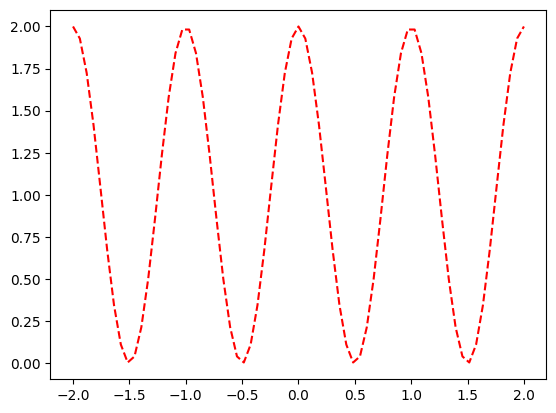

In [7]:
basis_a = FourierBasis.fn(x.unsqueeze(-1), 2).sum(1)
plt.plot(x, basis_a.real, color="r", linestyle="dashed")
plt.show()

In [8]:
points_min = points.min(0).values
points_offset = points + points_min.__mul__(points_min.__le__(0)).abs()
points_offset.min(0), points_offset.max(0)

(torch.return_types.min(
 values=tensor([0., 0.]),
 indices=tensor([0, 0])),
 torch.return_types.max(
 values=tensor([4., 2.]),
 indices=tensor([  66, 2211])))

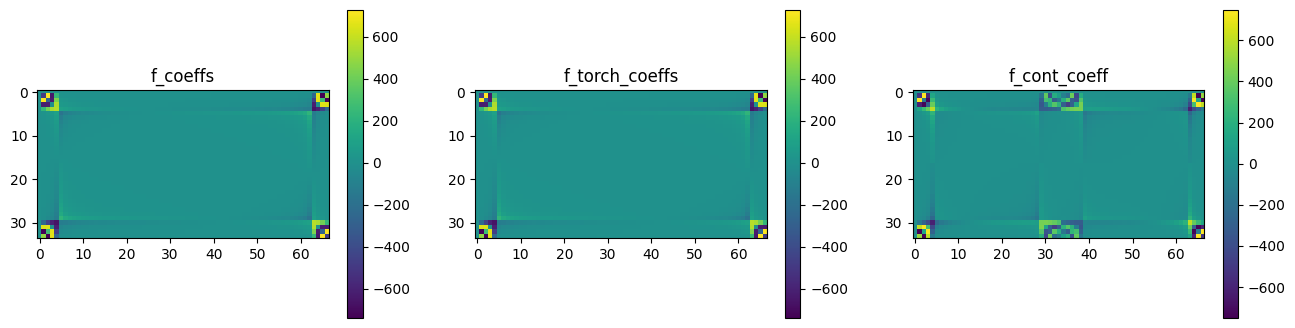

tensor(0.0211)

In [9]:
f_coeffs = FourierBasis.transform(f)
# 1.33 ms ± 245 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
f_torch_coeffs: torch.Tensor = torch.fft.fft2(f)
# 110 μs ± 4.77 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
basis_cont = FourierBasis.fn(points_offset, f_shape, periods=[3.96,1.98], constant=-2j * torch.pi)
f_cont_coeff = f.flatten(1).matmul(basis_cont.flatten(1)).view((f.shape[0], *basis_cont.shape[1:]))
# f_cont_coeff = (f[0].flatten() * basis_cont.transpose(0,-1)).sum(2).reshape(f_shape[::-1]).transpose(-1,0)
plt.figure(figsize=(16,4))
plt.subplot(131)
plt.imshow(f_coeffs[0].real)
plt.title("f_coeffs")
plt.colorbar()
plt.subplot(132)
plt.imshow(f_torch_coeffs[0].real)
plt.title("f_torch_coeffs")
plt.colorbar()
plt.subplot(133)
plt.imshow(f_cont_coeff[0].real)
plt.title("f_cont_coeff")
plt.colorbar()
plt.show()
torch.norm(f_coeffs - f_torch_coeffs, 2)

In [10]:
# the artefacts in the higher frequencies cause problems with the output
# f_cont_coeff[:,:,26:40] = f_torch_coeffs[:,:,26:40]

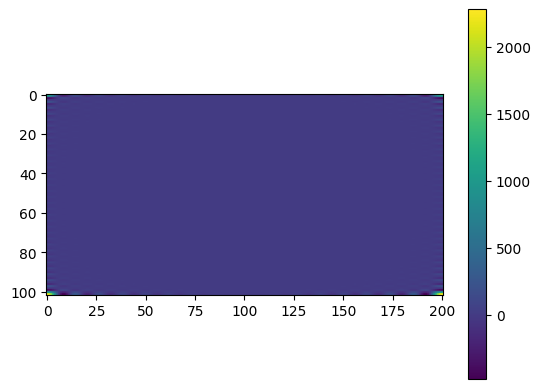

(torch.Size([20502, 34, 67]), torch.Size([102, 201]))

In [11]:
x_test = torch.linspace(-px / 2, px / 2, 67*3)
y_test = torch.linspace(-py / 2, py / 2, 34*3)
pp_test = torch.meshgrid([x_test, y_test], indexing="xy")
points_test = torch.vstack([p.flatten() for p in pp_test]).T + torch.Tensor(
    [px / 2, py / 2]
)

pp_test_shape = pp_test[0].shape
# points_test = points - torch.Tensor([[px / 2, py / 2]])
# pp_test_shape = pp_shape
period_inv = list(f_coeffs[0].shape)
modes_inv = list(f_coeffs[0].shape)
# period_inv = (np.array(f_coeffs[0].shape)).tolist()
basis_test = FourierBasis.fn(points_test, modes_inv, periods=periods)
basis_test_sum = basis_test.sum((1, 2)).reshape(pp_test_shape)
plt.imshow(basis_test_sum.real)
plt.colorbar()
plt.show()
basis_test.shape, pp_test_shape

In [12]:
f_pred, f_torch_pred, f_cont_pred = [
    # coeff_x_basis.sum((1, 2)).reshape(pp_test_shape[::-1]).transpose(-1, 0)
    coeff_x_basis.sum((1, 2)).reshape(pp_test_shape)
    # coeff_x_basis.sum((1, 2)).transpose(-1, 0).reshape(pp_test_shape)
    for coeff_x_basis in (
        f_coeffs[0] * basis_test,
        f_torch_coeffs[0] * basis_test,
        f_cont_coeff[0] * basis_test,
    )
]
scaling = 1.0 / np.prod(f_coeffs[0].shape)
f_pred = f_pred * scaling
# scaling = 1./np.prod(f_torch_coeffs[0].shape)
# f_torch_pred = f_torch_pred * scaling
scaling = 1.0 / np.prod(f_cont_coeff[0].shape)
f_cont_pred = f_cont_pred * scaling


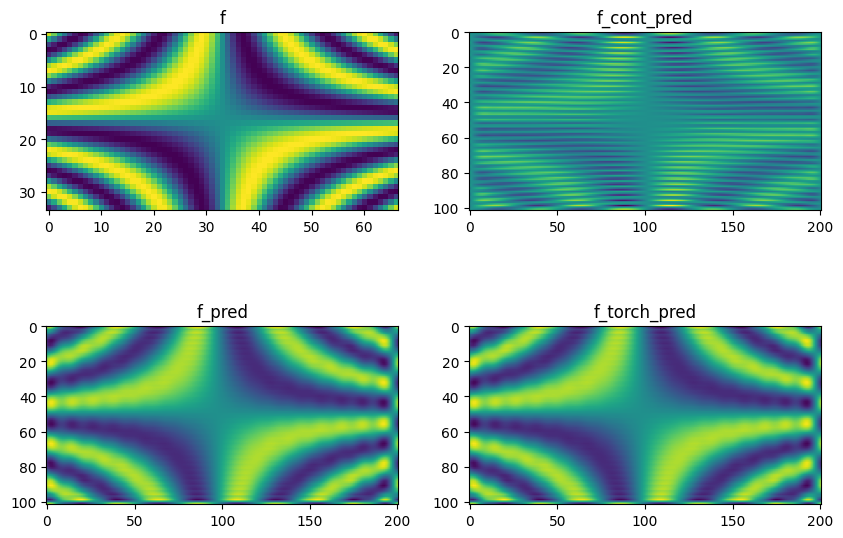

In [13]:
fig_pred, axs_pred = plt.subplots(2,2,figsize=[10,7])
axs_pred[0,0].imshow(f[0].real)
axs_pred[0,0].set_title('f')
axs_pred[0,1].imshow(f_cont_pred.real)
axs_pred[0,1].set_title('f_cont_pred')
axs_pred[1,0].imshow(f_pred.real)
axs_pred[1,0].set_title('f_pred')
axs_pred[1,1].imshow(f_torch_pred.real)
axs_pred[1,1].set_title('f_torch_pred')
# plt.colorbar()
plt.show()

f_torch_pred is not outputting the correct result because n/N isnt aligned to the domain of -px/2,px/2. instead it is aligned for 0,px

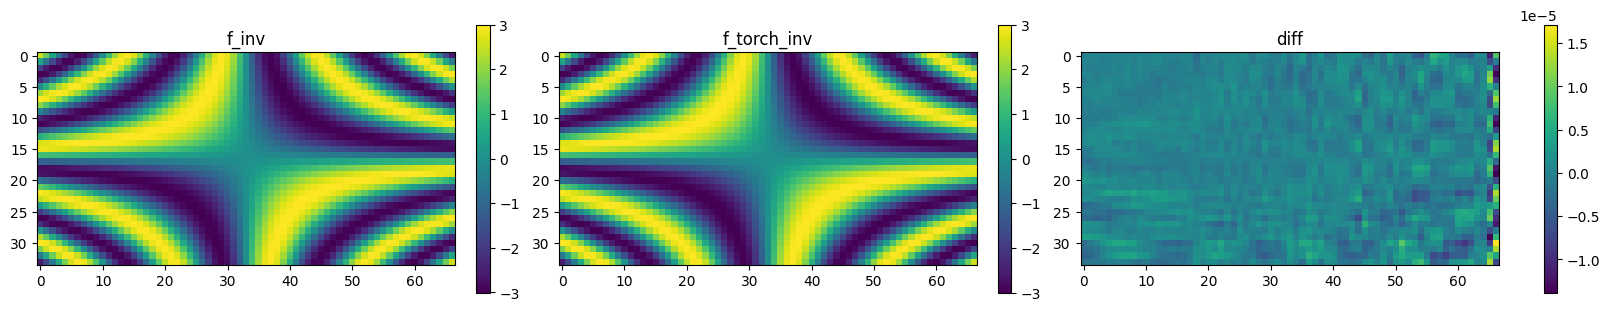

In [14]:
# ft = f_coeffs[0]
# ft = torch.fft.fftshift(f_coeffs[0])
# ft = torch.fft.ifftshift(f_torch_coeffs[0])
f_torch_inv = torch.fft.ifft2(f_coeffs)
f_inv = (
    FourierBasis.inv_transform(f_coeffs)
    # FourierBasis.inv_transform(f_coeffs, span=[(0, mode) for mode in f_shape])
)
f_inv.shape
# fig_inv, axs_inv = plt.subplots(1, 3, figsize=[15, 10])
plt.figure(figsize=(16, 3), constrained_layout=True)
plt.subplot(131)
plt.imshow(f_inv[0].real)
plt.title("f_inv")
plt.colorbar()
plt.subplot(132)
plt.imshow(f_torch_inv[0].real)
plt.title("f_torch_inv")
plt.colorbar()
plt.subplot(133)
plt.imshow((f_inv - f_torch_inv)[0].real)
plt.title("diff")
plt.colorbar()
plt.show()

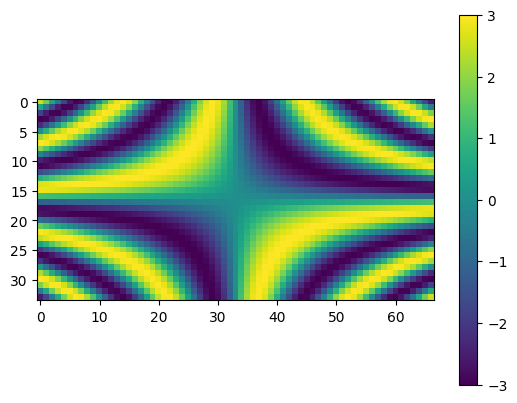

In [15]:
modes_integer = list(f_coeffs[0].shape)
scaling_integer = 1.0 / torch.Tensor(modes_integer).prod()
axes = []
for mode in modes_integer:
    # axes.append(torch.arange(-(mode - 1) // 2, (mode - 1) // 2 + 1))
    axes.append(torch.arange(mode))

axes_tiled = torch.meshgrid(axes, indexing="xy")
axes_tiled = [axis.flatten().unsqueeze(-1) for axis in axes_tiled]
points_integer = torch.concat(axes_tiled, 1)
# basis_integer = fn(points_integer, modes_integer)
basis_integer = FourierBasis.fn(points_integer, modes_integer, periods=modes_integer)

f_reconstruction = scaling_integer * (
    (f_coeffs[0] * basis_integer).sum((1, 2)).reshape(f_shape[::-1]).transpose(-1, 0)
)

plt.imshow(f_reconstruction.real)
plt.colorbar()
plt.show()

In [16]:
basis_integer.shape, basis_cont.shape

(torch.Size([2278, 34, 67]), torch.Size([2278, 34, 67]))

In [17]:
(basis_integer - basis_cont)[100]

tensor([[ 0.0000e+00+0.0000j,  8.9961e-04+0.3776j,  3.5338e-03+0.7416j,
          ...,  7.7118e-03-1.0789j,  3.5338e-03-0.7416j,
          8.9961e-04-0.3776j],
        [ 1.9320e+00-0.3930j,  1.9585e+00-0.4032j,  1.9145e+00-0.3989j,
          ...,  1.4510e+00-0.2844j,  1.6737e+00-0.3321j,
          1.8359e+00-0.3689j],
        [-2.5898e-01-0.6103j, -1.1580e-01-0.2711j,  3.3184e-02+0.0772j,
          ..., -6.0533e-01-1.4553j, -5.0807e-01-1.2133j,
         -3.9128e-01-0.9282j],
        ...,
        [ 1.4412e+00+0.9902j,  1.2663e+00+0.8656j,  1.0452e+00+0.7108j,
          ...,  1.6370e+00+1.1421j,  1.6298e+00+1.1313j,
          1.5638e+00+1.0799j],
        [-2.5898e-01+0.6103j, -3.9128e-01+0.9282j, -5.0807e-01+1.2133j,
          ...,  1.8262e-01-0.4219j,  3.3184e-02-0.0772j,
         -1.1580e-01+0.2711j],
        [ 1.9320e+00+0.3930j,  1.8359e+00+0.3689j,  1.6737e+00+0.3321j,
          ...,  1.8018e+00+0.3799j,  1.9145e+00+0.3989j,
          1.9585e+00+0.4032j]])

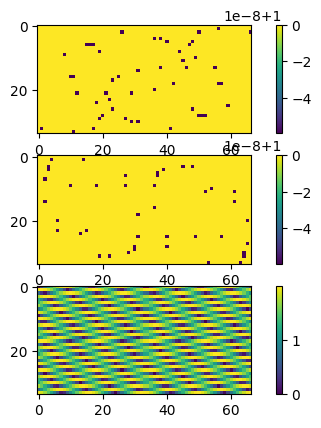

In [18]:
def tmp():
    n=100
    plt.subplot(311)
    plt.imshow(basis_integer[n].abs())
    plt.colorbar()
    plt.subplot(312)
    plt.imshow(basis_cont[n].abs())
    plt.colorbar()
    plt.subplot(313)
    plt.imshow((basis_integer - basis_cont)[n].abs())
    plt.colorbar()
    plt.show()

tmp()